In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MPBP_reframe/MatrixProductBP.jl`


In [2]:
using Revise
using Test, MatrixProductBP
using MatrixProductBP.Models
using Graphs, IndexedGraphs, Random, Distributions, SparseArrays
using TensorTrains
using Aqua

In [9]:
rng = MersenneTwister(111)

T = 2
β = 1.0
A = [0 1 0 0 0;
     1 0 1 1 0;
     0 1 0 0 0;
     0 1 0 0 0;
     0 0 0 0 0]

N = size(A, 1)
h = randn(rng, N)
# h = zeros(N)

J = randn(rng, N, N) .* A
J = 0.5 * (J + J')  # make symmetric

ising = Ising(J, h, β)
gl = Glauber(ising, T)

for i in 1:N
    r = 0.75
    gl.ϕ[i][1] .*= [r, 1-r]
end

bp = mpbp(deepcopy(gl))
X, observed = draw_node_observations!(bp, N; rng)
bp_fourier = mpbp_fourier(deepcopy(bp), K=200, σ=1/200)
;

In [10]:
svd_trunc = TruncBondThresh(10)
cb = CB_BP(bp; showprogress=false, info="Glauber")
cb_fourier = CB_BP(bp_fourier; showprogress=false, info="Glauber Fourier")
iterate!(bp; maxiter=20, svd_trunc, cb)
iterate!(bp_fourier; maxiter=20, svd_trunc, cb)
;

In [11]:
b_bp = beliefs(bp)
b_bp_fourier = beliefs(bp_fourier)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp]
p_bp_fourier = [[bbb[2] for bbb in bb] for bb in b_bp_fourier]

p_exact, Z_exact = exact_prob(bp)
b_exact = exact_marginals(bp; p_exact)
p_ex = [[bbb[2] for bbb in bb] for bb in b_exact]

f_bethe = bethe_free_energy(bp)
f_bethe_fourier = bethe_free_energy(bp_fourier)
Z_bp = exp(-f_bethe)
Z_bp_fourier = exp(-f_bethe_fourier)

f(x,i) = potts2spin(x,i)

r_bp = autocorrelations(f, bp)
r_bp_fourier = autocorrelations(f, bp_fourier)
r_exact = exact_autocorrelations(f, bp; p_exact)

c_bp = autocovariances(f, bp)
c_bp_fourier = autocovariances(f, bp_fourier)
c_exact = exact_autocovariances(f, bp; r = r_exact)

pb_bp = pair_beliefs(bp)[1]
pb_bp_fourier = pair_beliefs(bp_fourier)[1]
pb_bp2 = marginals.(pair_beliefs_as_mpem(bp)[1])
pb_bp2_fourier = marginals.(pair_beliefs_as_mpem(bp_fourier)[1])
;

Computing joint probability 100%|████████████████████████| Time: 0:00:00


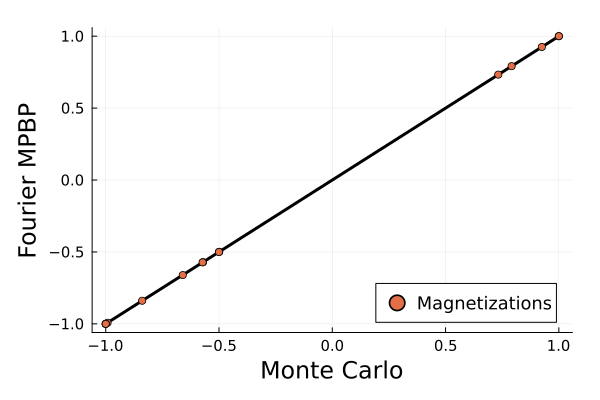

In [12]:
m = real.(means(potts2spin, bp))
m_fourier = real.(means(potts2spin, bp_fourier))
y_sc = reduce(vcat, y for y in m)
y_fourier_sc = reduce(vcat, y for y in m_fourier)

using Plots
pl2ba = plot(legend=:bottomright, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,400),
            xlabel="Monte Carlo",
            ylabel="Fourier MPBP")

plot!(pl2ba, -1.0:0.1:1.0, -1.0:0.1:1.0, label="", c=:black, lw=3)
plot!(pl2ba, y_sc, y_fourier_sc, st=:scatter, markerstrokecolor=:black, label="Magnetizations")

In [13]:
@show Z_exact Z_bp_fourier;

Z_exact = 0.13682428419499074
Z_bp_fourier = 0.13673566667727952


In [18]:
pb_bp_fourier

6-element Vector{Vector{Matrix{ComplexF64}}}:
 [[0.6892910696538956 + 1.2792225756436422e-17im 0.06021333299192554 - 1.661216755882908e-17im; 0.230371399599965 + 9.751434874281432e-18im 0.020124197754213858 - 5.931493071888784e-18im], [0.08185397400635823 + 1.5439440911047913e-17im 0.022346518974106208 - 1.9248236302422786e-17im; 0.7036890850049295 + 1.9605238307171855e-16im 0.19211042201460593 - 1.9224358768034377e-16im], [0.13295981263221393 + 1.667326358443946e-17im 0.0006542303327950339 - 6.35586787771012e-17im; 0.8621437684115363 + 5.679738357712662e-16im 0.004242188623454731 - 5.210884205786045e-16im]]
 [[0.6892910696538956 + 1.2798158559872385e-17im 0.230371399599965 + 9.741041030321263e-18im; 0.06021333299192554 - 1.6609751924450654e-17im 0.020124197754213858 - 5.929447665742921e-18im], [0.08185397400635822 + 1.5394975966186806e-17im 0.7036890850049297 + 1.9609016246230198e-16im; 0.022346518974106205 - 1.9284551403588164e-17im 0.19211042201460593 - 1.9220058702490067e-16im], [0